Configuration & Path Setup

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Dynamic Path Setup
current_dir = os.getcwd()
project_root = current_dir

# Climb up until we find 'src'
while not os.path.exists(os.path.join(project_root, 'src')):
    parent = os.path.dirname(project_root)
    if parent == project_root:
        raise FileNotFoundError("Could not find 'src'. Are you in the project folder?")
    project_root = parent

if project_root not in sys.path:
    sys.path.append(project_root)

DATA_PATH = os.path.join(project_root, 'data')
print(f"Project Root: {project_root}")
print(f"Data Path:    {DATA_PATH}")

# 2. Import Custom Modules
from src.data_loader import ClinicalTrialLoader
from src.preprocessing import get_pipeline

Project Root: /home/ruima/code/delaunan/clintrialpredict
Data Path:    /home/ruima/code/delaunan/clintrialpredict/data


 Smart Data Loading (Auto-Generation)

In [16]:
CSV_PATH = os.path.join(DATA_PATH, 'project_data.csv')
FORCE_REGENERATE = False  # Set to True if you changed code in data_loader.py

if os.path.exists(CSV_PATH) and not FORCE_REGENERATE:
    print(f">>> Loading existing dataset from: {CSV_PATH}")
    df = pd.read_csv(CSV_PATH)
else:
    print(">>> File not found (or forced regeneration). Triggering ETL pipeline...")
    loader = ClinicalTrialLoader(data_path=DATA_PATH)

    # 1. Load & Clean
    df = loader.load_and_clean()

    # 2. Add Features (Hierarchy, Competition, Text)
    df = loader.add_features(df)

    # 3. Save
    loader.save(df, filename='project_data.csv')

print(f"Data Ready. Shape: {df.shape}")

>>> File not found (or forced regeneration). Triggering ETL pipeline...
>>> 1. Loading Studies & Applying Filters...
    Core Cohort: 118587 trials
>>> 2. Engineering Features...
    -> Attaching Medical Hierarchy (Smart Lookup)...
    -> Calculating Competition (Broad & Niche)...
    -> Preparing Text Features...
    Save Complete.
>>> Saved 105336 rows to /home/ruima/code/delaunan/clintrialpredict/data/project_data.csv

--- DATA DISTRIBUTION ---
Class 0 (Success/Completed):  80.67%
Class 1 (Failure/Terminated): 19.33%
-------------------------
Data Ready. Shape: (105336, 32)


Temporal Split (Time Travel) <br>
Why: We sort by date to ensure strict separation of Past (Train) and Future (Test).

In [17]:
# 1. Sort by Start Year (Crucial for Time Series/Evolution)
df = df.sort_values('start_year').reset_index(drop=True)

# 2. Define Split Point (80% Train / 20% Test)
split_idx = int(len(df) * 0.8)

# 3. Split
train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

# 4. Define Features (X) and Target (y)
target_col = 'target'
# We drop ID and Status (Leakage)
drop_cols = [target_col, 'overall_status', 'nct_id']

X_train = train_df.drop(columns=drop_cols)
y_train = train_df[target_col]

X_test = test_df.drop(columns=drop_cols)
y_test = test_df[target_col]

# 5. Verification (The "Reality Check")
print(f"Train Set: {train_df['start_year'].min()} - {train_df['start_year'].max()} (n={len(train_df)})")
print(f"Test Set:  {test_df['start_year'].min()} - {test_df['start_year'].max()} (n={len(test_df)})")

Train Set: 2000.0 - 2019.0 (n=84268)
Test Set:  2019.0 - 2024.0 (n=21068)


dummy classifier (basline assessment)

In [18]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("--- BASELINE: DUMMY CLASSIFIER ---")

# 1. Create & Fit (Strategy: Always predict the majority class)

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)

# 2. Predict
y_pred_dummy = dummy.predict(X_test)

# 3. Basic Metrics
print(f"Accuracy:  {accuracy_score(y_test, y_pred_dummy):.4f}")
# Note: Precision/Recall will likely be 0.0 if the majority class is 0 (Completed)
print(f"Precision: {precision_score(y_test, y_pred_dummy, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_dummy):.4f}")
print("\nInterpretation: This is the score you get by doing absolutely nothing.")

--- BASELINE: DUMMY CLASSIFIER ---
Accuracy:  0.7283
Precision: 0.0000
Recall:    0.0000

Interpretation: This is the score you get by doing absolutely nothing.


Model training

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# 1. Build Pipeline
# We use class_weight='balanced' because clinical trials are often imbalanced (more successes than failures in some phases)
model = Pipeline(steps=[
    ('preprocessor', get_pipeline()),
    ('classifier', LogisticRegression(
        class_weight='balanced',
        solver='liblinear',
        penalty='l2',
        C=0.01,
        max_iter=1000,
        random_state=42
    ))
])

# 2. Fit
print(f"Training Logistic Regression on {len(X_train)} trials...")
model.fit(X_train, y_train)
print("Training Complete.")

Training Logistic Regression on 84268 trials...
Training Complete.


Evaluation & Visualization

--- MODEL PERFORMANCE METRICS ---
ROC-AUC Score:      0.7251  (0.5 = Random, 1.0 = Perfect)
PR-AUC Score:       0.4768   (Baseline: 0.2717)
----------------------------------------
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.91      0.40      0.56     15343
           1       0.36      0.89      0.51      5725

    accuracy                           0.54     21068
   macro avg       0.63      0.65      0.54     21068
weighted avg       0.76      0.54      0.55     21068



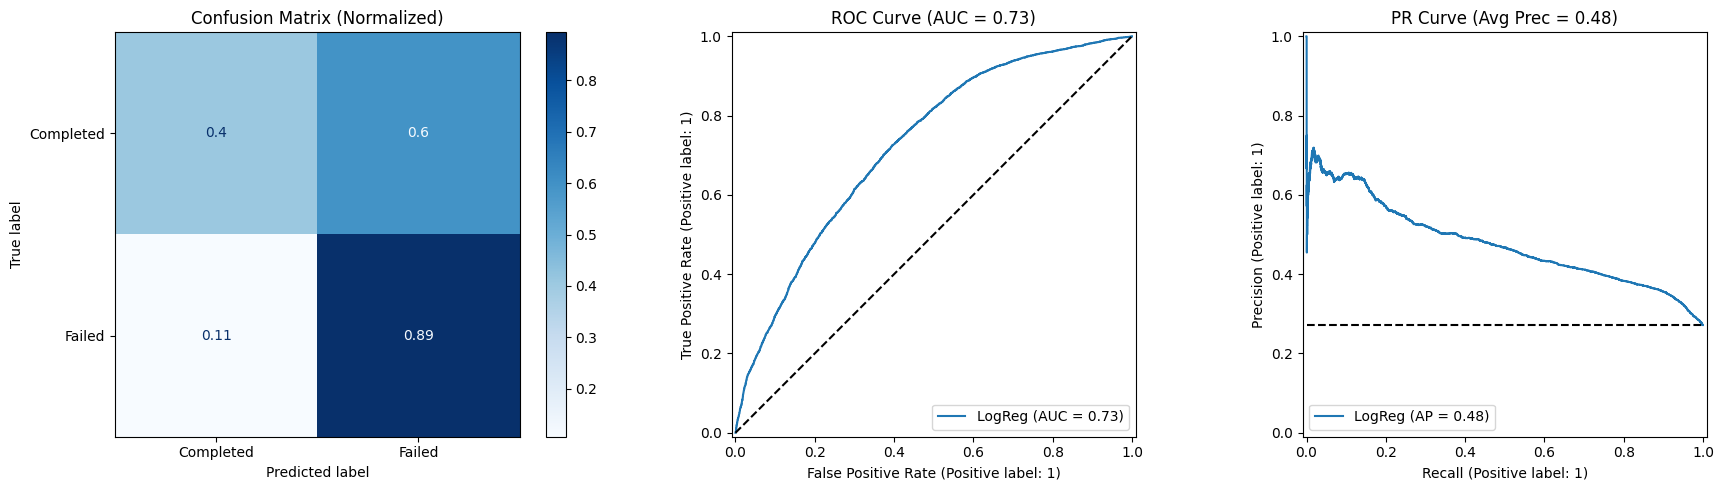

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

# 1. Get Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# 2. Calculate Advanced Metrics
roc_score = roc_auc_score(y_test, y_prob)
pr_score = average_precision_score(y_test, y_prob)

print(f"--- MODEL PERFORMANCE METRICS ---")
print(f"ROC-AUC Score:      {roc_score:.4f}  (0.5 = Random, 1.0 = Perfect)")
print(f"PR-AUC Score:       {pr_score:.4f}   (Baseline: {y_test.mean():.4f})")
print("-" * 40)
print("CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred))

# 3. Visualizations
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# A. Confusion Matrix (Normalized)
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    normalize='true',
    cmap='Blues',
    display_labels=['Completed', 'Failed'],
    ax=ax[0]
)
ax[0].set_title("Confusion Matrix (Normalized)")

# B. ROC Curve
RocCurveDisplay.from_predictions(y_test, y_prob, ax=ax[1], name='LogReg')
ax[1].set_title(f"ROC Curve (AUC = {roc_score:.2f})")
ax[1].plot([0, 1], [0, 1], "k--", label="Chance")

# C. Precision-Recall Curve
PrecisionRecallDisplay.from_predictions(y_test, y_prob, ax=ax[2], name='LogReg')
ax[2].set_title(f"PR Curve (Avg Prec = {pr_score:.2f})")
ax[2].plot([0, 1], [y_test.mean(), y_test.mean()], "k--", label="Baseline")

plt.tight_layout()
plt.show()

Save Model <br>
Why: Saves the trained pipeline so the Streamlit app can load it later.

In [22]:
import joblib
import os

# 1. Define the Output Directory
# We use 'project_root' from Cell 1.
models_dir = os.path.join(project_root, 'models')

# 2. Create directory if it doesn't exist
os.makedirs(models_dir, exist_ok=True)

# 3. Define Path & Save
model_filename = 'baseline_pipeline.joblib'
model_path = os.path.join(models_dir, model_filename)

joblib.dump(model, model_path)

# 4. Verification
print(f">>> SUCCESS: Model saved to {model_path}")
# Check size to ensure it's not empty (e.g., < 1KB would be suspicious)
print(f"    File Size: {os.path.getsize(model_path) / 1024:.2f} KB")

>>> SUCCESS: Model saved to /home/ruima/code/delaunan/clintrialpredict/models/baseline_pipeline.joblib
    File Size: 51.96 KB
